<a href="https://colab.research.google.com/github/bramyeon/sicss-happiness/blob/main/model-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>World Happiness:</b> Model Building v2
Summer Institute in Computational Social Science (SICSS-Korea) 2024 Team Project  

<b>Author:</b> Bryan Nathanael Wijaya ([bryannwijaya@kaist.ac.kr](mailto:bryannwijaya@kaist.ac.kr))  
<b>Team Members (ABC order):</b> Inkoo Kang, Ju Hee Jeung, Kyungmin Lee, Yumi Park

## Preliminaries
This notebook is set to run in Google Colaboratory environment. It assumes that the notebook is located at `/content/drive/My Drive/Colab Notebooks/sicss-korea-2024` and the dataset is saved at `data` directory under the previous path, which in turns contains `clean` and `inference` subdirectories to save preprocessed datasets and inferred life ladder values, respectively. It additionally assumes that there exists a directory named `model` where trained models can be saved. If this is not the case, make sure to modify the `ROOT_DIR` and `DATA_DIR` accordingly, make `clean` and `inference` subdirectories under `DATA_DIR`, and make a `model` directory under `ROOT_DIR`.

## Datasets
Refer to `README.md` in the [GitHub repository](https://github.com/bramyeon/sicss-happiness.git).

### If you find anything suspicious or wrong, do not hesitate to let me know via [email](mailto:bryannwijaya@kaist.ac.kr). Happy coding!


In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")

ROOT_DIR = '/content/drive/My Drive/Colab Notebooks/sicss-korea-2024'
DATA_DIR = 'data'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [42]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy import stats

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
SEED = 20244078

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [6]:
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/main-10layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/main-8layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/main-6layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/main-4layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/main-2layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/complex-10layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/complex-8layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/complex-6layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/complex-4layers-200epochs.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/inference/complex-2layers-200epoc

## Data Loading and Preprocessing

There are 4 datasets:
1. `df` is the combined dataset
2. `df_onehot` is the combined dataset with categorical column (i.e., `region`) being transformed into one-hot vector
3. `df_main` is the combined dataset without the extended features from the World Bank
4. `df_main_onehot` is the abovementioned dataset with categorical column (i.e., `region`) being transformed into one-hot vector

Here, for NaN entries, we fill them with the average feature value of the `region` where the `country` belongs in that `year`. However, after this step, if there are still NaN entries, we fill them with the average feature value of the `region` where the `country` belongs regardless of the year. Then, we removed the `country` name which is irrelevant for the model learning. We also visualized the correlation of each features in a heat map.

In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, "clean/core.csv"))
df.head(5)

,country,year,region,life ladder,log gdp per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect,avg temperature,max temperature,min temperature,gap temperature,gini index,co2 emissions (metric tons per capita)
0,Afghanistan,2008,South Asia,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,NaN,NaN,NaN,NaN,NaN,0.165573
1,Afghanistan,2009,South Asia,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,NaN,NaN,NaN,NaN,NaN,0.239507
2,Afghanistan,2010,South Asia,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,NaN,NaN,NaN,NaN,NaN,0.304230
3,Afghanistan,2011,South Asia,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,NaN,NaN,NaN,NaN,NaN,0.408965
4,Afghanistan,2012,South Asia,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,NaN,NaN,NaN,NaN,NaN,0.335061


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   country                                 2363 non-null   object 
 1   year                                    2363 non-null   int64  
 2   region                                  2363 non-null   object 
 3   life ladder                             2363 non-null   float64
 4   log gdp per capita                      2335 non-null   float64
 5   social support                          2350 non-null   float64
 6   healthy life expectancy at birth        2300 non-null   float64
 7   freedom to make life choices            2327 non-null   float64
 8   generosity                              2282 non-null   float64
 9   perceptions of corruption               2238 non-null   float64
 10  positive affect                         2339 non-null   floa

In [9]:
df.isna().sum()

country                                      0
year                                         0
region                                       0
life ladder                                  0
log gdp per capita                          28
social support                              13
healthy life expectancy at birth            63
freedom to make life choices                36
generosity                                  81
perceptions of corruption                  125
positive affect                             24
negative affect                             16
avg temperature                            983
max temperature                            983
min temperature                            983
gap temperature                            983
gini index                                1296
co2 emissions (metric tons per capita)     465
dtype: int64

In [10]:
for col in df.columns[3:]:
    # first, try to fill NaNs with the average of the region in the same year
    region_mean = df.groupby(['region', 'year'])[col].transform('mean')
    df[col] = df[col].fillna(region_mean)

df.isna().sum()

country                                     0
year                                        0
region                                      0
life ladder                                 0
log gdp per capita                          0
social support                              0
healthy life expectancy at birth            0
freedom to make life choices                0
generosity                                 25
perceptions of corruption                   0
positive affect                             1
negative affect                             0
avg temperature                           400
max temperature                           400
min temperature                           400
gap temperature                           400
gini index                                328
co2 emissions (metric tons per capita)    400
dtype: int64

In [11]:
for col in df.columns[3:]:
    # if there is no data for that region in that year, fill with the average of the region regardless of the year
    region_mean = df.groupby('region')[col].transform('mean')
    df[col] = df[col].fillna(region_mean)

df.isna().sum()

country                                   0
year                                      0
region                                    0
life ladder                               0
log gdp per capita                        0
social support                            0
healthy life expectancy at birth          0
freedom to make life choices              0
generosity                                0
perceptions of corruption                 0
positive affect                           0
negative affect                           0
avg temperature                           0
max temperature                           0
min temperature                           0
gap temperature                           0
gini index                                0
co2 emissions (metric tons per capita)    0
dtype: int64

In [12]:
df_onehot = pd.get_dummies(df, columns=['region'], dtype=float)
del df_onehot['country']

df_onehot.head(5)

,year,life ladder,log gdp per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect,...,region_Central and Eastern Europe,region_Commonwealth of Independent States,region_East Asia,region_Latin America and Caribbean,region_Middle East and North Africa,region_North America and ANZ,region_South Asia,region_Southeast Asia,region_Sub-Saharan Africa,region_Western Europe
0,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   year                                       2363 non-null   int64  
 1   life ladder                                2363 non-null   float64
 2   log gdp per capita                         2363 non-null   float64
 3   social support                             2363 non-null   float64
 4   healthy life expectancy at birth           2363 non-null   float64
 5   freedom to make life choices               2363 non-null   float64
 6   generosity                                 2363 non-null   float64
 7   perceptions of corruption                  2363 non-null   float64
 8   positive affect                            2363 non-null   float64
 9   negative affect                            2363 non-null   float64
 10  avg temperature         

In [14]:
df_onehot.isnull().sum()

year                                         0
life ladder                                  0
log gdp per capita                           0
social support                               0
healthy life expectancy at birth             0
freedom to make life choices                 0
generosity                                   0
perceptions of corruption                    0
positive affect                              0
negative affect                              0
avg temperature                              0
max temperature                              0
min temperature                              0
gap temperature                              0
gini index                                   0
co2 emissions (metric tons per capita)       0
region_Central and Eastern Europe            0
region_Commonwealth of Independent States    0
region_East Asia                             0
region_Latin America and Caribbean           0
region_Middle East and North Africa          0
region_North 

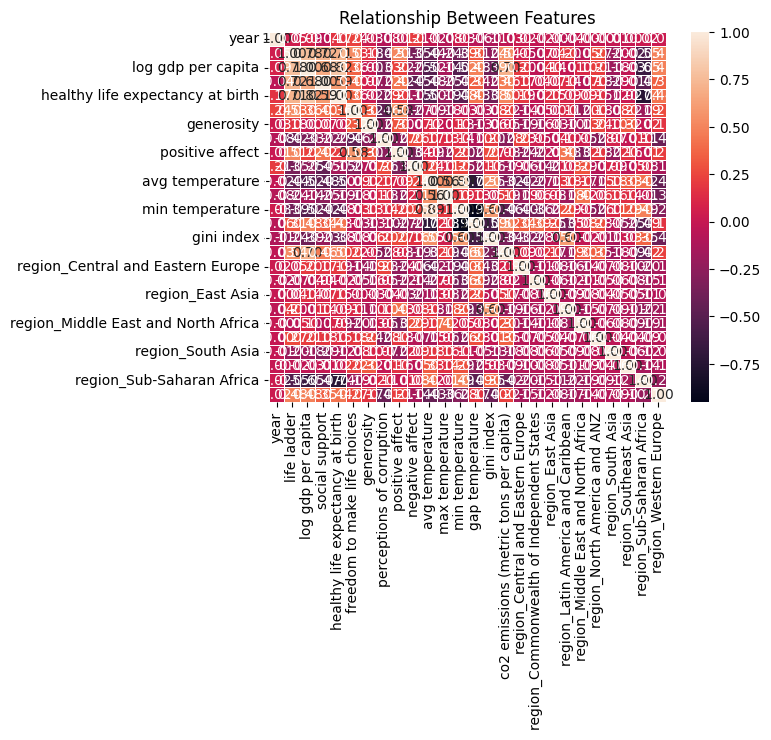

In [15]:
df_onehot_corr_matrix = df_onehot.corr()
sns.heatmap(df_onehot_corr_matrix, annot = True, fmt ='.2f', linewidth = .7)
plt.title('Relationship Between Features')
plt.show()

## Train/Test Splitting

Train split consists of the data in 2005-2022, while test split consists of the data in 2023. Here, we remove irrelevant features such as the `year` of the data record. We have two sets of training and testing data loaders.
1. `main_train_loader` and `main_test_loader`: The loader for model built upon only the main features
2. `train_loader` and `test_loader`: The loader for model built upon all features, including those from the World Bank

In [16]:
BATCH_SIZE = 32

In [17]:
df_onehot['bias'] = -1.

df_train = df_onehot[df_onehot['year'] != 2023]
df_test = df_onehot[df_onehot['year'] == 2023]

del df_train['year']
del df_test['year']

df_train_label = torch.tensor(df_train['life ladder'].tolist(), dtype=torch.float).to(device)
df_test_label = torch.tensor(df_test['life ladder'].tolist(), dtype=torch.float).to(device)

del df_train['life ladder']
del df_test['life ladder']

df_train_data = torch.tensor(df_train.values, dtype=torch.float).to(device)
df_test_data = torch.tensor(df_test.values, dtype=torch.float).to(device)

df_train_data.shape, df_train_label.shape, df_test_data.shape, df_test_label.shape

(torch.Size([2225, 25]),
 torch.Size([2225]),
 torch.Size([138, 25]),
 torch.Size([138]))

In [18]:
train_dataset = torch.utils.data.TensorDataset(df_train_data, df_train_label)
test_dataset = torch.utils.data.TensorDataset(df_test_data, df_test_label)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
all_in = df_train_data.shape[1]
print(f'Number of input features: {all_in}')

Number of input features: 25


## Model Building and Initialization

We built 5 models with different number of layers, thus different complexity. The model is based on vanilla neural network.

In [20]:
class Regressor(nn.Module):
    def __init__(self, features):
        super(Regressor, self).__init__()


        self.layers = []
        for i in range(len(features)-1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(features[-1], 1))

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [21]:
model = Regressor([20, 45, 32, 42, 256])
input_test = torch.randn((534,20))
output = model(input_test)
print(output.size())

torch.Size([534, 1])


In [22]:
LUCKY_NUMBER = 42

lr = 0.001
epochs = 200
beta1, beta2 = 0.9, 0.999
criterion = nn.MSELoss()

In [23]:
class Model:
    def __init__(self, features, lr, beta1, beta2, epochs):
        self.features = features
        self.model = Regressor(self.features)
        self.model = self.model.to(device)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        self.train_loss_epoch = None
        self.test_err_epoch = None

    def update(self, train_loss_epoch, test_err_epoch):
        self.train_loss_epoch = train_loss_epoch
        self.test_err_epoch = test_err_epoch

In [24]:
models = [  Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*16, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER], lr, beta1, beta2, epochs) ]

## Model Training

In [25]:
def train(model, trainloader, criterion):

    model.model.train()
    losses = []

    for i, (data, label) in enumerate(trainloader):
        data, label = data.to(device), label.to(device)
        model.optimizer.zero_grad()
        output = model.model(data)
        loss = criterion(output, label.reshape(-1,1))
        losses.append(loss)
        loss.backward()
        model.optimizer.step()

    loss_epoch = sum(losses)/len(losses)
    return loss_epoch.item()

In [26]:
def eval(model, testloader, show=False):

    model.model.eval()

    sums = []
    labels = []
    outputs = []
    with torch.no_grad():
        for i, (data, label) in enumerate(testloader):
            data, label = data.to(device), label.to(device)
            output = model.model(data)
            squared_error = (output - label.reshape(-1,1))**2
            sum_squared_error = torch.sum(squared_error)
            sums.append(sum_squared_error)
            if show:
                labels += label.tolist()
                outputs += [elem[0] for elem in output.tolist()]

    error_epoch = sum(sums)/len(sums)
    result = pd.DataFrame({'label': labels, 'output': outputs})
    return error_epoch.item(), result

In [27]:
for i in range(len(models)):
    print(f"\nTraining for CORE (main features + 4 temperatures + CO2 emission + Gini index) model with features={models[i].features}, lr={models[i].lr}, beta1={models[i].beta1}, beta2={models[i].beta2}, epochs={models[i].epochs}")
    train_loss_epoch = []
    test_err_epoch = []
    show = False
    for epoch in range(models[i].epochs):
        if epoch == models[i].epochs-1:
            show = True
        train_loss_epoch.append(train(models[i], train_loader, criterion))
        test_err, result = eval(models[i], test_loader, show=show)
        test_err_epoch.append(test_err)
        if (epoch+1) % 20 == 0:
            print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss_epoch[-1]:5.2f}\tTest Sum of Squared Error: {test_err_epoch[-1]:7.2f}')
            torch.save(models[i].model.state_dict(), os.path.join(ROOT_DIR, f'model/core-{len(models[i].features)}layers-{epoch+1}epochs.pth'))
        if show:
            result.to_csv(os.path.join(DATA_DIR, f'inference/core-{len(models[i].features)}layers-{epoch+1}epochs.csv'), index=False)
    models[i].update(train_loss_epoch, test_err_epoch)


Training for CORE (main features + 4 temperatures + CO2 emission + Gini index) model with features=[25, 42, 84, 168, 336, 672, 336, 168, 84, 42], lr=0.001, beta1=0.9, beta2=0.999, epochs=200
Epoch: 20	Train Loss:  0.37	Test Sum of Squared Error:   13.76
Epoch: 40	Train Loss:  0.32	Test Sum of Squared Error:   10.17
Epoch: 60	Train Loss:  0.30	Test Sum of Squared Error:    8.86
Epoch: 80	Train Loss:  0.25	Test Sum of Squared Error:   14.49
Epoch: 100	Train Loss:  0.24	Test Sum of Squared Error:    8.06
Epoch: 120	Train Loss:  0.23	Test Sum of Squared Error:    7.67
Epoch: 140	Train Loss:  0.24	Test Sum of Squared Error:    9.96
Epoch: 160	Train Loss:  0.19	Test Sum of Squared Error:    6.47
Epoch: 180	Train Loss:  0.18	Test Sum of Squared Error:    6.44
Epoch: 200	Train Loss:  0.21	Test Sum of Squared Error:    6.86

Training for CORE (main features + 4 temperatures + CO2 emission + Gini index) model with features=[25, 42, 84, 168, 336, 168, 84, 42], lr=0.001, beta1=0.9, beta2=0.999, e

## Plotting

We visualize the training results here.

In [40]:
def plot():
    figure = plt.figure(figsize=(12,4))

    f1 = figure.add_subplot(121)
    f2 = figure.add_subplot(122)

    for model in models:
        epochs = range(1, model.epochs+1)
        f1.plot(epochs, model.train_loss_epoch, label=f'Core model, {len(model.features)} layers')
    f1.set_title(f'Training loss (MSE Loss)')
    f1.set_xlabel('Epochs')
    f1.set_ylabel('Training Loss')
    f1.legend()

    for model in models:
        f2.plot(epochs, model.test_err_epoch, label=f'Core model, {len(model.features)} layers')
    f2.set_title(f'Sum of squared error on testing dataset')
    f2.set_xlabel('Epochs')
    f2.set_ylabel('Test sum of squared error')
    f2.legend()

    plt.show()
    print()
    for model in models:
        print(f"Sum of squared error on testing dataset for core model with {len(model.features)} layers:\t{model.test_err_epoch[-1]:.4f}")

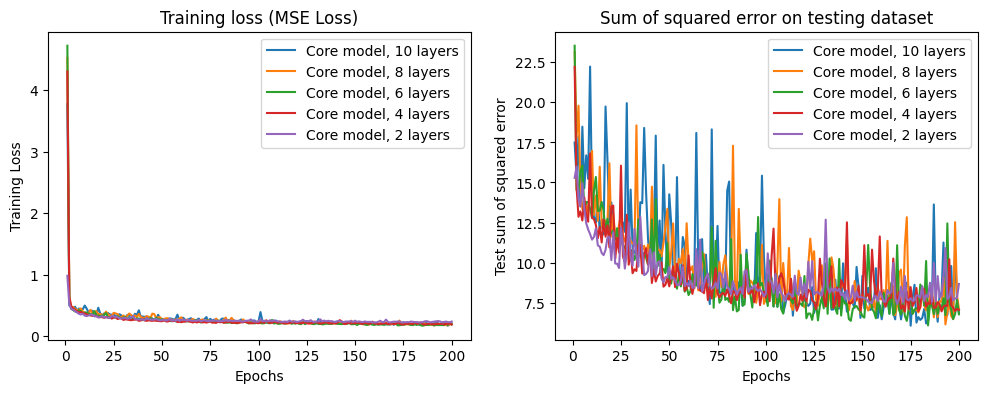


Sum of squared error on testing dataset for core model with 10 layers:	6.8582
Sum of squared error on testing dataset for core model with 8 layers:	7.1051
Sum of squared error on testing dataset for core model with 6 layers:	6.7840
Sum of squared error on testing dataset for core model with 4 layers:	7.0549
Sum of squared error on testing dataset for core model with 2 layers:	8.6755


In [41]:
plot()

## Example Usage

In [30]:
model = Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs)
checkpoint = torch.load(os.path.join(ROOT_DIR, 'model/core-6layers-200epochs.pth'))
model.model.load_state_dict(checkpoint)
model.model.to(device)

Regressor(
  (model): Sequential(
    (0): Linear(in_features=25, out_features=42, bias=True)
    (1): ReLU()
    (2): Linear(in_features=42, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=168, bias=True)
    (5): ReLU()
    (6): Linear(in_features=168, out_features=84, bias=True)
    (7): ReLU()
    (8): Linear(in_features=84, out_features=42, bias=True)
    (9): ReLU()
    (10): Linear(in_features=42, out_features=1, bias=True)
  )
)

In [31]:
data = df_test_data
label = df_test_label

In [32]:
model.model.eval()

labels = []
outputs = []
with torch.no_grad():
    data, label = data.to(device), label.to(device)
    output = model.model(data)
    squared_error = (output - label.reshape(-1,1))**2
    mean_squared_error = torch.sum(squared_error)/len(squared_error)
    if show:
        labels += label.tolist()
        outputs += [elem[0] for elem in output.tolist()]

result = pd.DataFrame({'label': labels, 'output': outputs})

print(f'MSE: {mean_squared_error:.4f}\n')
result.head(30)

MSE: 0.2458



,label,output
0,1.446,2.944672
1,5.445,5.678932
2,6.393,6.137774
3,5.679,5.289123
4,7.025,7.069113
5,6.636,7.054363
6,5.214,5.393251
7,5.959,6.335808
8,4.114,4.546084
9,6.944,6.982059


In [33]:
data.shape

torch.Size([138, 25])

In [34]:
features_dict = dict()
for i, col in enumerate(df_test.columns):
    features_dict[col] = i
    print(f'{i} {col}')

0 log gdp per capita
1 social support
2 healthy life expectancy at birth
3 freedom to make life choices
4 generosity
5 perceptions of corruption
6 positive affect
7 negative affect
8 avg temperature
9 max temperature
10 min temperature
11 gap temperature
12 gini index
13 co2 emissions (metric tons per capita)
14 region_Central and Eastern Europe
15 region_Commonwealth of Independent States
16 region_East Asia
17 region_Latin America and Caribbean
18 region_Middle East and North Africa
19 region_North America and ANZ
20 region_South Asia
21 region_Southeast Asia
22 region_Sub-Saharan Africa
23 region_Western Europe
24 bias


In [35]:
df.describe()

,year,life ladder,log gdp per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect,avg temperature,max temperature,min temperature,gap temperature,gini index,co2 emissions (metric tons per capita)
count,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000
mean,2014.763860,5.483566,9.398408,0.809447,63.476400,0.749807,-0.000031,0.744889,0.651235,0.273460,65.347380,84.984396,40.632789,44.351607,37.722736,4.576755
std,5.059436,1.125522,1.150331,0.120999,6.797761,0.138880,0.159274,0.180324,0.106091,0.087003,12.583855,8.158480,25.720409,25.478805,6.531697,4.731592
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000,17.421642,47.400000,-47.700000,0.000000,23.200000,0.022746
25%,2011.000000,4.647000,8.505500,0.744000,59.480000,0.659500,-0.108000,0.691000,0.571000,0.209000,53.168721,80.939483,18.700000,20.683593,32.500000,0.818590
50%,2015.000000,5.449000,9.507000,0.834000,65.200000,0.770000,-0.022000,0.793000,0.663000,0.263000,68.719800,85.264706,45.400000,42.000000,37.293287,3.315705
75%,2019.000000,6.323500,10.386000,0.904000,68.531250,0.861000,0.089000,0.864000,0.736500,0.327000,75.636014,89.428571,63.923529,63.900000,42.071881,7.069726
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000,90.100000,110.000000,90.100000,153.300000,63.400000,39.582140


In [49]:
def analyze(model, sample_nums, feature, minval, maxval, n_sample=5000, legend=False, save=True):

    assert min(sample_nums) >= 0 and max(sample_nums) < len(df_test_data), f'''Sample number must be between 0 and {len(df_test_data)-1} (inclusive)'''
    rancol = torch.linspace(minval, maxval, n_sample)
    outputs = []

    for i in tqdm(range(len(sample_nums)), "Generating data and evaluating"):
        sample = data[sample_nums[i]]
        # print(f'Sampled test data {i+1} is: \n{sample}\n')

        # print(f'[SAMPLE {i+1}] Generating {n_sample} data from sampled test data with {feature} values equally distributed from {minval} to {maxval}...')
        tensor = sample.repeat(n_sample, 1)
        tensor[:, features_dict[feature]] = rancol
        # print(f'Test data {i+1} is: \n{tensor}\n')
        # print(f'The test data {i+1} shape is: {tensor.shape}\n')

        model.model.eval()
        with torch.no_grad():
            tensor = tensor.to(device)
            output = model.model(tensor)
            output = [elem[0] for elem in output.tolist()]
            outputs.append(output)

    figure = plt.figure(figsize=(12,4))
    f1 = figure.add_subplot(121)
    f2 = figure.add_subplot(122)

    for i in tqdm(range(len(outputs)), "Plotting"):
        f1.plot(rancol, outputs[i], label=f'Sample {i+1}')

    f1.set_title(f'Relationship of {feature} and life ladder')
    f1.set_xlabel(feature)
    f1.set_ylabel('predicted life ladder')
    f1.set_xlim(minval, maxval)
    f1.grid(True)
    if legend:
        f1.legend()

    outputs = np.array(outputs)
    mean_output = np.mean(outputs, axis=0)
    std_output = np.std(outputs, axis=0)
    sem_output = std_output / np.sqrt(len(sample_nums))

    confidence_interval = stats.t.ppf(0.975, df=len(sample_nums)-1) * sem_output

    f2.plot(rancol, mean_output, label='Average')
    f2.fill_between(rancol, mean_output - confidence_interval, mean_output + confidence_interval, color='blue', alpha=0.1, label='95% CI')

    f2.set_title(f'Averaged relationship of {feature} and life ladder')
    f2.set_xlabel(feature)
    f2.set_ylabel('predicted life ladder')
    f2.set_xlim(minval, maxval)
    f2.grid(True)
    if legend:
        f2.legend()

    if save:
        plt.savefig(os.path.join(DATA_DIR, f"inference/core-{len(model.features)}layers-200epochs-{feature.lower().replace(' ','-')}.png"), bbox_inches='tight')

    plt.show()

In [50]:
sample_nums = range(len(df_test_data))

### Analyzing the effect of GDP per capita to happiness score


Plotting: 100%|██████████| 138/138 [02:46<00:00,  1.20s/it]


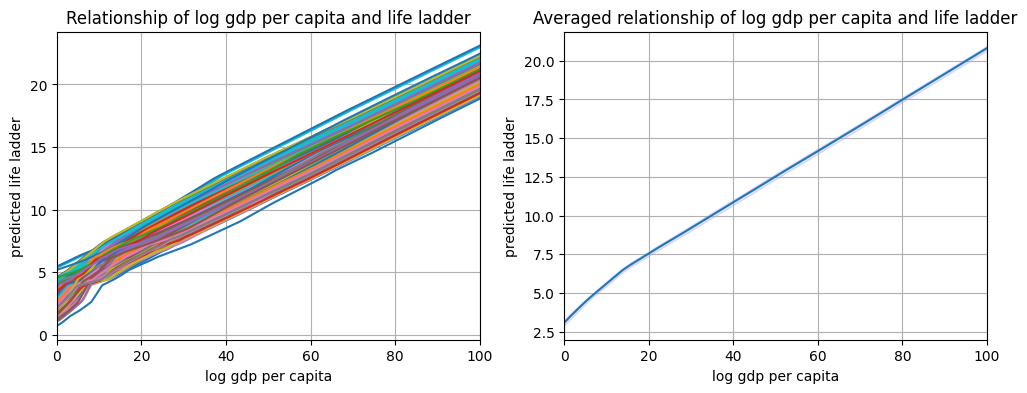

In [51]:
analyze(model, sample_nums, 'log gdp per capita', 0, 100, 50000)

### Analyzing the effect of Gini index per capita to happiness score


Plotting: 100%|██████████| 138/138 [02:49<00:00,  1.23s/it]


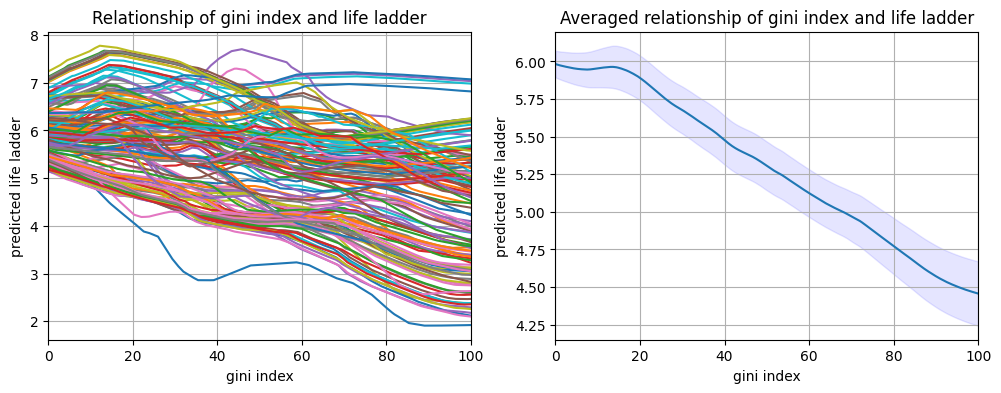

In [52]:
analyze(model, sample_nums, 'gini index', 0, 100, 50000)

### Analyzing the effect of annual average temperature to happiness score


Plotting: 100%|██████████| 138/138 [02:50<00:00,  1.24s/it]


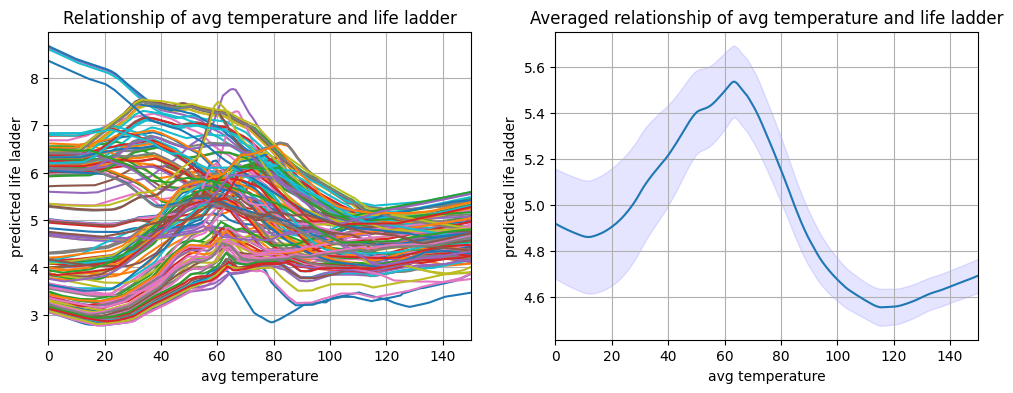

In [53]:
analyze(model, sample_nums, 'avg temperature', 0, 150, 50000)

### Analyzing the effect of annual maximum temperature to happiness score


Plotting: 100%|██████████| 138/138 [02:51<00:00,  1.24s/it]


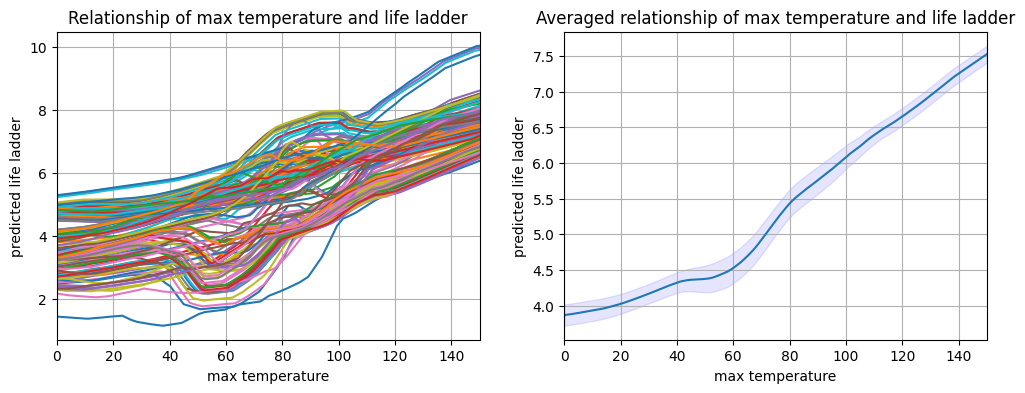

In [54]:
analyze(model, sample_nums, 'max temperature', 0, 150, 50000)

### Analyzing the effect of annual minimum temperature to happiness score


Plotting: 100%|██████████| 138/138 [02:48<00:00,  1.22s/it]


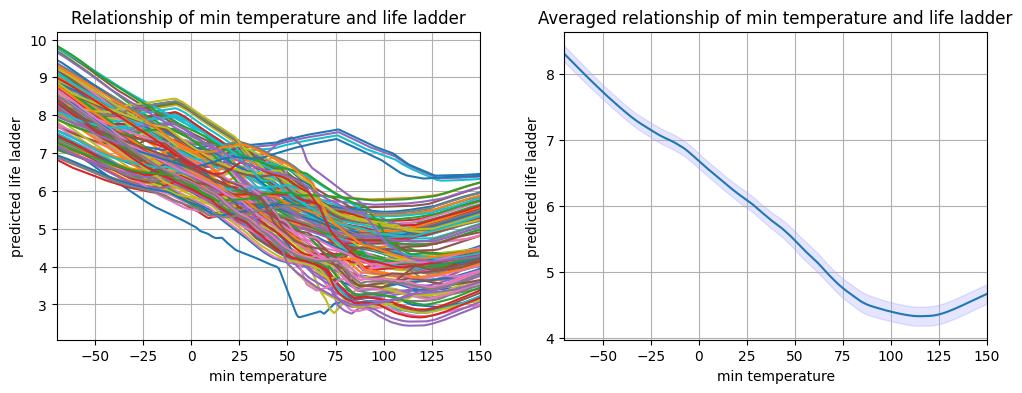

In [55]:
analyze(model, sample_nums, 'min temperature', -70, 150, 50000)

### Analyzing the effect of annual maximum and minimum temperature gap to happiness score


Plotting: 100%|██████████| 138/138 [02:43<00:00,  1.19s/it]


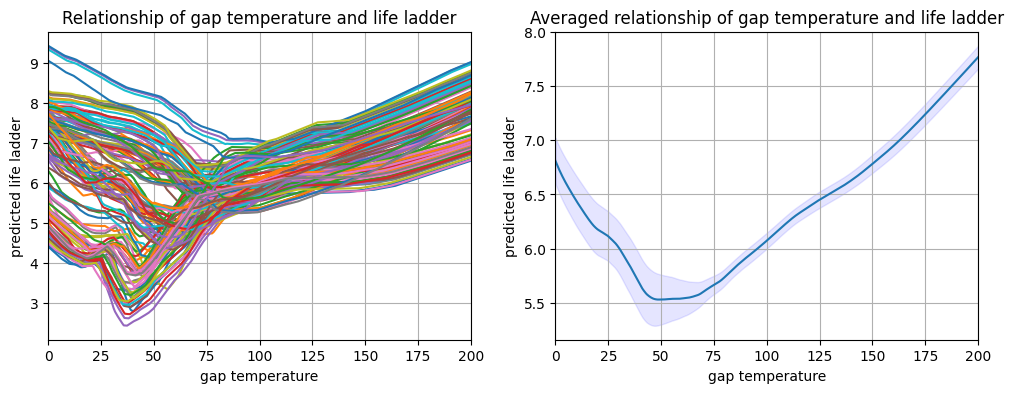

In [56]:
analyze(model, sample_nums, 'gap temperature', 0, 200, 50000)

### Analyzing the effect of CO2 emissions per capita to happiness score


Plotting: 100%|██████████| 138/138 [02:45<00:00,  1.20s/it]


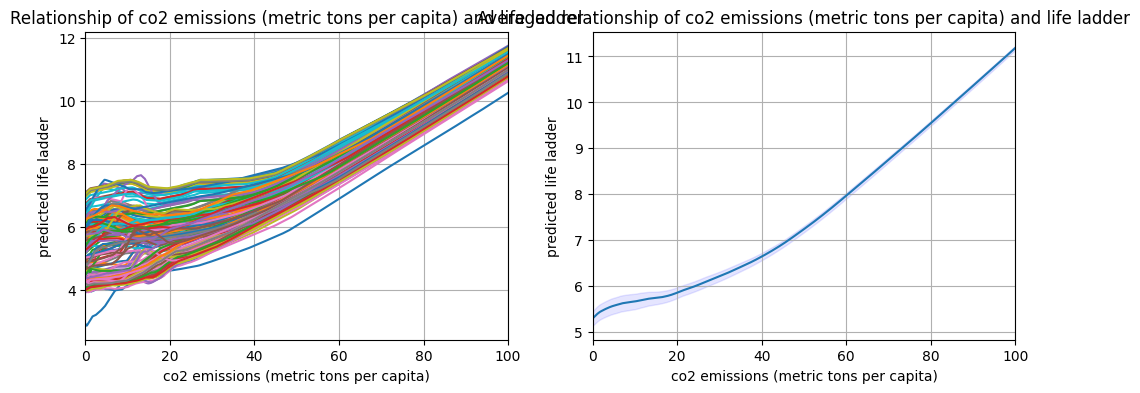

In [57]:
analyze(model, sample_nums, 'co2 emissions (metric tons per capita)', 0, 100, 50000)